# Song lyrics exploration - Part 3: Word clouds

Word clouds are a fun and oftentimes helpful technique for visualizing natural language data. They can show words scaled by any metric, although term frequency and term-frequency-inverse-document-frequency (TF-IDF) are the most common metrics. For a multi-class or multi-label classification problem, word clouds can highlight the similarities and differences between separate classes by treating each class as its own document to compare with all others. The word clouds seen here were made with the `WordCloud` generator by [amueller](https://github.com/amueller/word_cloud), with pre-processing done via `gensim` and `nltk`.

In the case of heavy metal genre classification, term frequency alone would not be very illuminating: the genres visualized here share a lot of common themes. TF-IDF does much better at picking out the words that are unique to a genre: black metal lyrics deal with topics like the occult, religion, and nature; death metal focuses on the obscene and horrifying; heavy metal revolves around themes more familiar to rock and pop; power metal adopts the vocabulary of fantasies and histories; and thrash metal sings of violence, war, and... beer? The full corpus word cloud shows themes common to all heavy metal genres.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud

from nlp import get_stopwords, tokenize

C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Data

In [2]:
df = pd.read_csv('songs-ml-1pct.csv')
genres = df.columns[1:]

### Combine songs from same genre into documents

Before combining all the songs into a corpus, [stop words](https://en.wikipedia.org/wiki/Stop_word) (common words that aren't critical to the meaning of a text, e.g. "the" and "of") are removed using a directory of stop words in various languages. I don't recall where I got my stop words but it's easy to find repositories of stop words like [Alir3z4/stop-words](https://github.com/Alir3z4/stop-words) and [6/stopwords-json](https://github.com/6/stopwords-json).

In [3]:
tokenize_kwargs = dict(english_only=True, stopwords=get_stopwords())
corpus = []
for genre in genres:
    song_tokens = df[df[genre] == 1].lyrics.apply(lambda x: ' '.join(tokenize(x, **tokenize_kwargs)))
    genre_tokens = ' '.join(song_tokens).split()
    corpus.append(genre_tokens)

In [4]:
print("genre word counts:")
for i, genre in enumerate(genres):
    print(f"{genre:<15}{len(corpus[i])}")

genre word counts:
black          481811
death          1004374
deathcore      50846
doom           201536
folk           99556
gothic         130302
grindcore      91243
heavy          473360
metalcore      87639
power          629682
progressive    309687
symphonic      176693
thrash         532979


In [5]:
print("genre vocabulary sizes:")
for i, genre in enumerate(genres):
    print(f"{genre:<15}{len(set(corpus[i]))}")

genre vocabulary sizes:
black          17609
death          23055
deathcore      7225
doom           12044
folk           9552
gothic         9801
grindcore      11602
heavy          13490
metalcore      7676
power          14134
progressive    14391
symphonic      11332
thrash         16552


# Word cloud

In [6]:
def get_wordcloud_frequencies(texts, tfidf=False, min_tf=0, min_tf_pct=0, min_df=1):
    print("creating dictionary")
    dictionary = Dictionary(texts)
    print("generating bag-of-words representation")
    vectors = [dictionary.doc2bow(text) for text in texts]
    if min_tf > 0:
        print("filtering out words that occur less than 'min_tf' times in a document")
        vectors = [[v for v in vector if v[1] > min_tf] for vector in vectors]
    if min_tf_pct > 0:
        print("filtering out words that comprises less than 'min_tf_pct' of a document")
        assert min_tf_pct <= 100, "min_tf_pct must be in the interval [0, 100]"
        text_sizes = [len(text) for text in texts]
        vectors = [[v for v in vector if v[1] > 0.01 * min_tf_pct * text_size] for vector, text_size in zip(vectors, text_sizes)]
    if min_df > 1:
        print("filtering out words that occur in fewer than 'min_df' documents")
        ids = [[id_ for id_, _ in vector] for vector in vectors]
        ids_unique = set(sum(ids, []))
        ids_unique_filtered = []
        for id_ in ids_unique:
            if sum(id_ in text_ids for text_ids in ids) > min_df:
                ids_unique_filtered.append(id_)
        vectors = [[v for v in vector if v[0] in ids_unique_filtered] for vector in vectors]
    if tfidf:
        print("generating TF-IDF model")
        tfidf = TfidfModel(vectors)
        vectors = [tfidf[vector] for vector in vectors]
    print("generating frequency dictionaries for WordCloud")
    out = []
    for vector in vectors:
        out.append({dictionary[id_]: count for id_, count in vector})
    return out

### Full corpus

creating dictionary
generating bag-of-words representation
generating frequency dictionaries for WordCloud


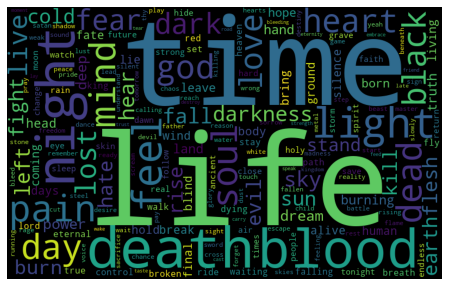

In [7]:
full_text = sum(corpus, [])
word_freqs = get_wordcloud_frequencies([full_text])
word_cloud = WordCloud(width=800, height=500).fit_words(word_freqs[0])
plt.figure(figsize=(8, 5))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### By genre

creating dictionary
generating bag-of-words representation
filtering out words that comprises less than 'min_tf_pct' of a document
generating TF-IDF model
generating frequency dictionaries for WordCloud


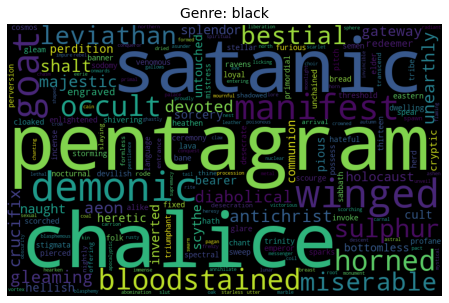

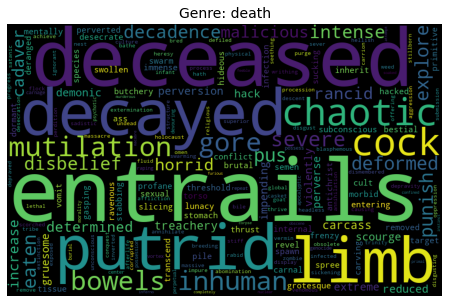

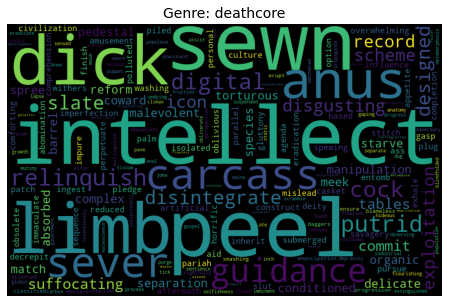

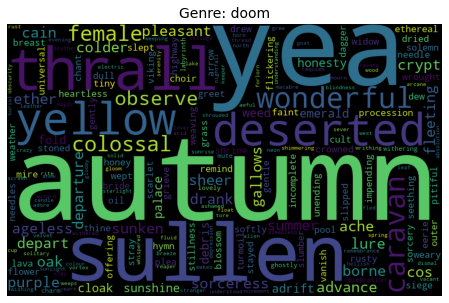

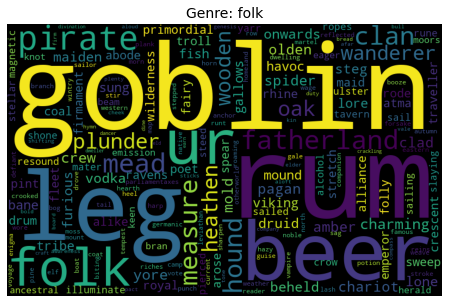

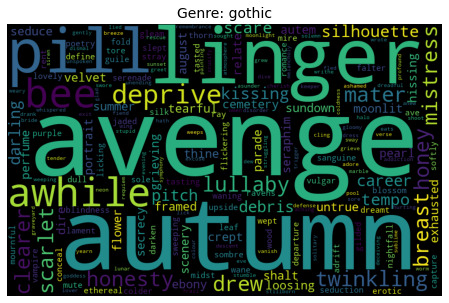

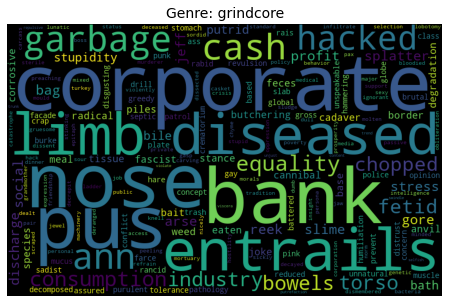

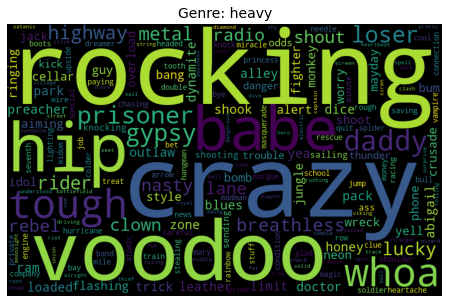

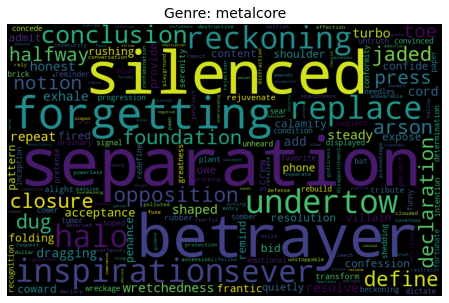

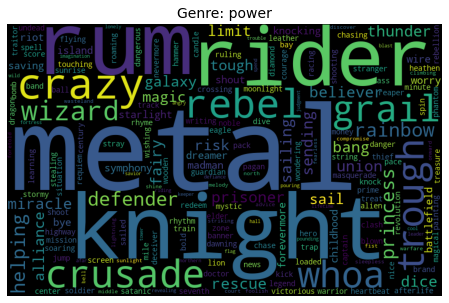

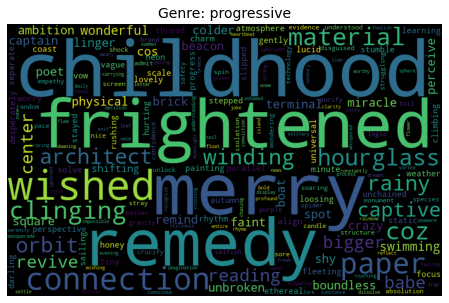

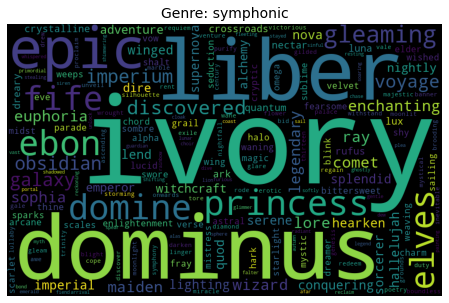

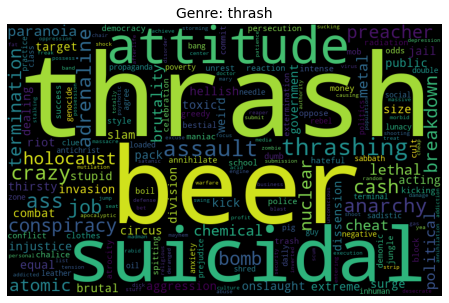

In [8]:
word_freqs = get_wordcloud_frequencies(corpus, tfidf=True, min_tf_pct=0.01)

for i, genre in enumerate(genres):
    word_cloud = WordCloud(width=800, height=500).fit_words(word_freqs[i])
    plt.figure(figsize=(8, 5))
    plt.imshow(word_cloud)
    plt.title(f'Genre: {genre}', fontsize=14)
    plt.axis('off')
    plt.show()